# Deep Learning: Laparoscopic segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from pytorch_Uformer import modelPool
from pytorch_Uformer import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm

c:\Users\sandr\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Descomentar la siguiente linea si tu ordenador no tiene una GPU NVIDIA, y deseas que el código funcione en una CPU en lugar de una GPU
#torch.cuda.is_available(), torch.cuda.get_device_name(0)   

In [4]:
SEED = 17
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 3e-4
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob(f'../*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 120:-120,:]
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 120:-120,:]
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = modelPool.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 6464 examples in the training set...
[INFO] found 1616 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.TverskyLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
bestIoU = 0
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	torch.cuda.empty_cache()
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")
	
	if avgTestIoU > bestIoU:
		bestIoU = avgTestIoU
		torch.save(uformer.state_dict(), '../models/uformerpool_tversky.pth')
		print('Best IoU improved. Model saved.')
		
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')

[INFO] training the network...


  0%|          | 0/202 [00:00<?, ?it/s]

100%|██████████| 202/202 [38:27<00:00, 11.42s/it]


[INFO] EPOCH: 1/100
Train loss: 0.336750, Test loss: 0.2191, Train IoU: 0.5077, Test IoU: 0.6598, Train Dice: 0.6633, Test Dice: 0.8009
Best IoU improved. Model saved.


100%|██████████| 202/202 [38:05<00:00, 11.31s/it]


[INFO] EPOCH: 2/100
Train loss: 0.188073, Test loss: 0.1697, Train IoU: 0.6840, Test IoU: 0.7293, Train Dice: 0.8119, Test Dice: 0.8503
Best IoU improved. Model saved.


100%|██████████| 202/202 [38:42<00:00, 11.50s/it]


[INFO] EPOCH: 3/100
Train loss: 0.159567, Test loss: 0.1537, Train IoU: 0.7251, Test IoU: 0.7532, Train Dice: 0.8404, Test Dice: 0.8663
Best IoU improved. Model saved.


100%|██████████| 202/202 [39:06<00:00, 11.61s/it]


[INFO] EPOCH: 4/100
Train loss: 0.145896, Test loss: 0.1432, Train IoU: 0.7456, Test IoU: 0.7692, Train Dice: 0.8541, Test Dice: 0.8768
Best IoU improved. Model saved.


100%|██████████| 202/202 [39:31<00:00, 11.74s/it]


[INFO] EPOCH: 5/100
Train loss: 0.138152, Test loss: 0.1311, Train IoU: 0.7575, Test IoU: 0.7879, Train Dice: 0.8618, Test Dice: 0.8889
Best IoU improved. Model saved.


100%|██████████| 202/202 [39:59<00:00, 11.88s/it]


[INFO] EPOCH: 6/100
Train loss: 0.129402, Test loss: 0.1241, Train IoU: 0.7711, Test IoU: 0.7990, Train Dice: 0.8706, Test Dice: 0.8959
Best IoU improved. Model saved.


100%|██████████| 202/202 [40:41<00:00, 12.09s/it]


[INFO] EPOCH: 7/100
Train loss: 0.122456, Test loss: 0.1220, Train IoU: 0.7821, Test IoU: 0.8024, Train Dice: 0.8775, Test Dice: 0.8980
Best IoU improved. Model saved.


100%|██████████| 202/202 [41:07<00:00, 12.21s/it]


[INFO] EPOCH: 8/100
Train loss: 0.120252, Test loss: 0.1176, Train IoU: 0.7856, Test IoU: 0.8094, Train Dice: 0.8797, Test Dice: 0.9024
Best IoU improved. Model saved.


100%|██████████| 202/202 [41:40<00:00, 12.38s/it]


[INFO] EPOCH: 9/100
Train loss: 0.115403, Test loss: 0.1116, Train IoU: 0.7934, Test IoU: 0.8192, Train Dice: 0.8846, Test Dice: 0.9084
Best IoU improved. Model saved.


100%|██████████| 202/202 [41:23<00:00, 12.29s/it]


[INFO] EPOCH: 10/100
Train loss: 0.112640, Test loss: 0.1099, Train IoU: 0.7978, Test IoU: 0.8220, Train Dice: 0.8874, Test Dice: 0.9101
Best IoU improved. Model saved.


100%|██████████| 202/202 [41:16<00:00, 12.26s/it]


[INFO] EPOCH: 11/100
Train loss: 0.111310, Test loss: 0.1096, Train IoU: 0.7999, Test IoU: 0.8224, Train Dice: 0.8887, Test Dice: 0.9104
Best IoU improved. Model saved.


100%|██████████| 202/202 [41:28<00:00, 12.32s/it]


[INFO] EPOCH: 12/100
Train loss: 0.108632, Test loss: 0.1069, Train IoU: 0.8043, Test IoU: 0.8268, Train Dice: 0.8914, Test Dice: 0.9131
Best IoU improved. Model saved.


100%|██████████| 202/202 [42:07<00:00, 12.51s/it]


[INFO] EPOCH: 13/100
Train loss: 0.106735, Test loss: 0.1049, Train IoU: 0.8074, Test IoU: 0.8301, Train Dice: 0.8933, Test Dice: 0.9151
Best IoU improved. Model saved.


100%|██████████| 202/202 [42:05<00:00, 12.50s/it]


[INFO] EPOCH: 14/100
Train loss: 0.105064, Test loss: 0.1038, Train IoU: 0.8101, Test IoU: 0.8319, Train Dice: 0.8949, Test Dice: 0.9162
Best IoU improved. Model saved.


100%|██████████| 202/202 [42:24<00:00, 12.59s/it]


[INFO] EPOCH: 15/100
Train loss: 0.103626, Test loss: 0.1029, Train IoU: 0.8125, Test IoU: 0.8334, Train Dice: 0.8964, Test Dice: 0.9171
Best IoU improved. Model saved.


100%|██████████| 202/202 [42:32<00:00, 12.64s/it]


[INFO] EPOCH: 16/100
Train loss: 0.103125, Test loss: 0.1034, Train IoU: 0.8133, Test IoU: 0.8327, Train Dice: 0.8969, Test Dice: 0.9166


100%|██████████| 202/202 [42:51<00:00, 12.73s/it]


[INFO] EPOCH: 17/100
Train loss: 0.102397, Test loss: 0.1012, Train IoU: 0.8145, Test IoU: 0.8362, Train Dice: 0.8976, Test Dice: 0.9188
Best IoU improved. Model saved.


100%|██████████| 202/202 [43:15<00:00, 12.85s/it]


[INFO] EPOCH: 18/100
Train loss: 0.101067, Test loss: 0.1003, Train IoU: 0.8168, Test IoU: 0.8378, Train Dice: 0.8989, Test Dice: 0.9197
Best IoU improved. Model saved.


100%|██████████| 202/202 [39:05<00:00, 11.61s/it]


[INFO] EPOCH: 19/100
Train loss: 0.100455, Test loss: 0.1009, Train IoU: 0.8177, Test IoU: 0.8368, Train Dice: 0.8995, Test Dice: 0.9191


100%|██████████| 202/202 [39:35<00:00, 11.76s/it]


[INFO] EPOCH: 20/100
Train loss: 0.099910, Test loss: 0.1011, Train IoU: 0.8186, Test IoU: 0.8364, Train Dice: 0.9001, Test Dice: 0.9189


100%|██████████| 202/202 [43:04<00:00, 12.80s/it]


[INFO] EPOCH: 21/100
Train loss: 0.099654, Test loss: 0.0988, Train IoU: 0.8190, Test IoU: 0.8403, Train Dice: 0.9003, Test Dice: 0.9212
Best IoU improved. Model saved.


100%|██████████| 202/202 [46:42<00:00, 13.87s/it]


[INFO] EPOCH: 22/100
Train loss: 0.098113, Test loss: 0.0978, Train IoU: 0.8216, Test IoU: 0.8420, Train Dice: 0.9019, Test Dice: 0.9222
Best IoU improved. Model saved.


100%|██████████| 202/202 [45:14<00:00, 13.44s/it]


[INFO] EPOCH: 23/100
Train loss: 0.098946, Test loss: 0.0982, Train IoU: 0.8202, Test IoU: 0.8412, Train Dice: 0.9011, Test Dice: 0.9218


100%|██████████| 202/202 [48:11<00:00, 14.31s/it]


[INFO] EPOCH: 24/100
Train loss: 0.096749, Test loss: 0.0950, Train IoU: 0.8239, Test IoU: 0.8465, Train Dice: 0.9033, Test Dice: 0.9250
Best IoU improved. Model saved.


100%|██████████| 202/202 [52:22<00:00, 15.56s/it]


[INFO] EPOCH: 25/100
Train loss: 0.095375, Test loss: 0.0940, Train IoU: 0.8261, Test IoU: 0.8483, Train Dice: 0.9046, Test Dice: 0.9260
Best IoU improved. Model saved.


100%|██████████| 202/202 [56:32<00:00, 16.80s/it]


[INFO] EPOCH: 26/100
Train loss: 0.093728, Test loss: 0.0940, Train IoU: 0.8289, Test IoU: 0.8483, Train Dice: 0.9063, Test Dice: 0.9260
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:02:13<00:00, 18.48s/it]


[INFO] EPOCH: 27/100
Train loss: 0.093024, Test loss: 0.0906, Train IoU: 0.8301, Test IoU: 0.8539, Train Dice: 0.9070, Test Dice: 0.9294
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:08:00<00:00, 20.20s/it]


[INFO] EPOCH: 28/100
Train loss: 0.092074, Test loss: 0.0907, Train IoU: 0.8317, Test IoU: 0.8537, Train Dice: 0.9079, Test Dice: 0.9293


100%|██████████| 202/202 [1:15:12<00:00, 22.34s/it]


[INFO] EPOCH: 29/100
Train loss: 0.091487, Test loss: 0.0898, Train IoU: 0.8326, Test IoU: 0.8554, Train Dice: 0.9085, Test Dice: 0.9302
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:28:20<00:00, 26.24s/it]


[INFO] EPOCH: 30/100
Train loss: 0.090213, Test loss: 0.0893, Train IoU: 0.8348, Test IoU: 0.8562, Train Dice: 0.9098, Test Dice: 0.9307
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:34:44<00:00, 28.14s/it]


[INFO] EPOCH: 31/100
Train loss: 0.087201, Test loss: 0.0842, Train IoU: 0.8398, Test IoU: 0.8648, Train Dice: 0.9128, Test Dice: 0.9358
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:40:17<00:00, 29.79s/it]


[INFO] EPOCH: 32/100
Train loss: 0.083347, Test loss: 0.0818, Train IoU: 0.8464, Test IoU: 0.8688, Train Dice: 0.9167, Test Dice: 0.9382
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:42:52<00:00, 30.56s/it]


[INFO] EPOCH: 33/100
Train loss: 0.081459, Test loss: 0.0807, Train IoU: 0.8496, Test IoU: 0.8708, Train Dice: 0.9185, Test Dice: 0.9393
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:43:30<00:00, 30.74s/it]


[INFO] EPOCH: 34/100
Train loss: 0.080594, Test loss: 0.0786, Train IoU: 0.8511, Test IoU: 0.8743, Train Dice: 0.9194, Test Dice: 0.9414
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:44:18<00:00, 30.98s/it]


[INFO] EPOCH: 35/100
Train loss: 0.079177, Test loss: 0.0786, Train IoU: 0.8535, Test IoU: 0.8744, Train Dice: 0.9208, Test Dice: 0.9414
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:46:11<00:00, 31.54s/it]


[INFO] EPOCH: 36/100
Train loss: 0.078254, Test loss: 0.0776, Train IoU: 0.8551, Test IoU: 0.8761, Train Dice: 0.9217, Test Dice: 0.9424
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:47:57<00:00, 32.07s/it]


[INFO] EPOCH: 37/100
Train loss: 0.077503, Test loss: 0.0768, Train IoU: 0.8564, Test IoU: 0.8774, Train Dice: 0.9225, Test Dice: 0.9432
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:46:08<00:00, 31.53s/it]


[INFO] EPOCH: 38/100
Train loss: 0.077688, Test loss: 0.0768, Train IoU: 0.8560, Test IoU: 0.8775, Train Dice: 0.9223, Test Dice: 0.9432
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:43:49<00:00, 30.84s/it]


[INFO] EPOCH: 39/100
Train loss: 0.076941, Test loss: 0.0760, Train IoU: 0.8574, Test IoU: 0.8788, Train Dice: 0.9231, Test Dice: 0.9440
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:45:53<00:00, 31.45s/it]


[INFO] EPOCH: 40/100
Train loss: 0.076336, Test loss: 0.0769, Train IoU: 0.8584, Test IoU: 0.8773, Train Dice: 0.9237, Test Dice: 0.9431


100%|██████████| 202/202 [1:46:35<00:00, 31.66s/it]


[INFO] EPOCH: 41/100
Train loss: 0.075466, Test loss: 0.0755, Train IoU: 0.8599, Test IoU: 0.8798, Train Dice: 0.9245, Test Dice: 0.9445
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:46:00<00:00, 31.49s/it]


[INFO] EPOCH: 42/100
Train loss: 0.075622, Test loss: 0.0757, Train IoU: 0.8596, Test IoU: 0.8794, Train Dice: 0.9244, Test Dice: 0.9443


100%|██████████| 202/202 [1:46:38<00:00, 31.67s/it]


[INFO] EPOCH: 43/100
Train loss: 0.074589, Test loss: 0.0744, Train IoU: 0.8614, Test IoU: 0.8817, Train Dice: 0.9254, Test Dice: 0.9456
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:47:41<00:00, 31.99s/it]


[INFO] EPOCH: 44/100
Train loss: 0.074965, Test loss: 0.0752, Train IoU: 0.8608, Test IoU: 0.8803, Train Dice: 0.9250, Test Dice: 0.9448


100%|██████████| 202/202 [1:46:08<00:00, 31.53s/it]


[INFO] EPOCH: 45/100
Train loss: 0.074838, Test loss: 0.0744, Train IoU: 0.8610, Test IoU: 0.8816, Train Dice: 0.9252, Test Dice: 0.9456


100%|██████████| 202/202 [1:36:18<00:00, 28.61s/it]


[INFO] EPOCH: 46/100
Train loss: 0.073818, Test loss: 0.0735, Train IoU: 0.8627, Test IoU: 0.8831, Train Dice: 0.9262, Test Dice: 0.9465
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:26:57<00:00, 25.83s/it]


[INFO] EPOCH: 47/100
Train loss: 0.065994, Test loss: 0.0561, Train IoU: 0.8764, Test IoU: 0.9137, Train Dice: 0.9340, Test Dice: 0.9639
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:24:18<00:00, 25.04s/it]


[INFO] EPOCH: 48/100
Train loss: 0.057385, Test loss: 0.0543, Train IoU: 0.8916, Test IoU: 0.9170, Train Dice: 0.9426, Test Dice: 0.9657
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:27:35<00:00, 26.02s/it]


[INFO] EPOCH: 49/100
Train loss: 0.056102, Test loss: 0.0541, Train IoU: 0.8938, Test IoU: 0.9173, Train Dice: 0.9439, Test Dice: 0.9659
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:26:41<00:00, 25.75s/it]


[INFO] EPOCH: 50/100
Train loss: 0.055044, Test loss: 0.0520, Train IoU: 0.8957, Test IoU: 0.9211, Train Dice: 0.9450, Test Dice: 0.9680
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:25:36<00:00, 25.43s/it]


[INFO] EPOCH: 51/100
Train loss: 0.054010, Test loss: 0.0528, Train IoU: 0.8976, Test IoU: 0.9197, Train Dice: 0.9460, Test Dice: 0.9672


100%|██████████| 202/202 [1:21:10<00:00, 24.11s/it]


[INFO] EPOCH: 52/100
Train loss: 0.053177, Test loss: 0.0477, Train IoU: 0.8991, Test IoU: 0.9290, Train Dice: 0.9468, Test Dice: 0.9723
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:19:18<00:00, 23.56s/it]


[INFO] EPOCH: 53/100
Train loss: 0.046934, Test loss: 0.0427, Train IoU: 0.9104, Test IoU: 0.9381, Train Dice: 0.9531, Test Dice: 0.9773
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:17:00<00:00, 22.87s/it]


[INFO] EPOCH: 54/100
Train loss: 0.043546, Test loss: 0.0409, Train IoU: 0.9166, Test IoU: 0.9415, Train Dice: 0.9565, Test Dice: 0.9791
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:14:52<00:00, 22.24s/it]


[INFO] EPOCH: 55/100
Train loss: 0.041470, Test loss: 0.0387, Train IoU: 0.9204, Test IoU: 0.9456, Train Dice: 0.9585, Test Dice: 0.9813
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:14:23<00:00, 22.10s/it]


[INFO] EPOCH: 56/100
Train loss: 0.039941, Test loss: 0.0385, Train IoU: 0.9233, Test IoU: 0.9458, Train Dice: 0.9601, Test Dice: 0.9815
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:13:43<00:00, 21.90s/it]


[INFO] EPOCH: 57/100
Train loss: 0.038815, Test loss: 0.0365, Train IoU: 0.9254, Test IoU: 0.9495, Train Dice: 0.9612, Test Dice: 0.9835
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:12:23<00:00, 21.50s/it]


[INFO] EPOCH: 58/100
Train loss: 0.038509, Test loss: 0.0369, Train IoU: 0.9259, Test IoU: 0.9488, Train Dice: 0.9615, Test Dice: 0.9831


100%|██████████| 202/202 [1:11:18<00:00, 21.18s/it]


[INFO] EPOCH: 59/100
Train loss: 0.037112, Test loss: 0.0354, Train IoU: 0.9285, Test IoU: 0.9517, Train Dice: 0.9629, Test Dice: 0.9846
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:10:00<00:00, 20.79s/it]


[INFO] EPOCH: 60/100
Train loss: 0.036231, Test loss: 0.0342, Train IoU: 0.9302, Test IoU: 0.9538, Train Dice: 0.9638, Test Dice: 0.9858
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:10:39<00:00, 20.99s/it]


[INFO] EPOCH: 61/100
Train loss: 0.035390, Test loss: 0.0333, Train IoU: 0.9317, Test IoU: 0.9556, Train Dice: 0.9646, Test Dice: 0.9867
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:14:19<00:00, 22.08s/it]


[INFO] EPOCH: 62/100
Train loss: 0.035197, Test loss: 0.0338, Train IoU: 0.9321, Test IoU: 0.9546, Train Dice: 0.9648, Test Dice: 0.9862


100%|██████████| 202/202 [1:17:43<00:00, 23.09s/it]


[INFO] EPOCH: 63/100
Train loss: 0.034608, Test loss: 0.0329, Train IoU: 0.9332, Test IoU: 0.9563, Train Dice: 0.9654, Test Dice: 0.9871
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:18:43<00:00, 23.38s/it]


[INFO] EPOCH: 64/100
Train loss: 0.033790, Test loss: 0.0328, Train IoU: 0.9347, Test IoU: 0.9566, Train Dice: 0.9662, Test Dice: 0.9872
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:21:19<00:00, 24.16s/it]


[INFO] EPOCH: 65/100
Train loss: 0.033726, Test loss: 0.0327, Train IoU: 0.9349, Test IoU: 0.9567, Train Dice: 0.9663, Test Dice: 0.9873
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:20:50<00:00, 24.01s/it]


[INFO] EPOCH: 66/100
Train loss: 0.033068, Test loss: 0.0322, Train IoU: 0.9361, Test IoU: 0.9576, Train Dice: 0.9669, Test Dice: 0.9878
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:20:21<00:00, 23.87s/it]


[INFO] EPOCH: 67/100
Train loss: 0.032851, Test loss: 0.0326, Train IoU: 0.9365, Test IoU: 0.9570, Train Dice: 0.9671, Test Dice: 0.9874


100%|██████████| 202/202 [1:19:39<00:00, 23.66s/it]


[INFO] EPOCH: 68/100
Train loss: 0.033283, Test loss: 0.0322, Train IoU: 0.9357, Test IoU: 0.9577, Train Dice: 0.9667, Test Dice: 0.9878
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:15:27<00:00, 22.41s/it]


[INFO] EPOCH: 69/100
Train loss: 0.032254, Test loss: 0.0314, Train IoU: 0.9376, Test IoU: 0.9592, Train Dice: 0.9677, Test Dice: 0.9886
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:15:45<00:00, 22.50s/it]


[INFO] EPOCH: 70/100
Train loss: 0.031567, Test loss: 0.0305, Train IoU: 0.9389, Test IoU: 0.9608, Train Dice: 0.9684, Test Dice: 0.9895
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:16:25<00:00, 22.70s/it]


[INFO] EPOCH: 71/100
Train loss: 0.031149, Test loss: 0.0307, Train IoU: 0.9397, Test IoU: 0.9605, Train Dice: 0.9689, Test Dice: 0.9893


100%|██████████| 202/202 [1:17:51<00:00, 23.13s/it]


[INFO] EPOCH: 72/100
Train loss: 0.031107, Test loss: 0.0303, Train IoU: 0.9398, Test IoU: 0.9613, Train Dice: 0.9689, Test Dice: 0.9897
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:18:16<00:00, 23.25s/it]


[INFO] EPOCH: 73/100
Train loss: 0.031022, Test loss: 0.0299, Train IoU: 0.9399, Test IoU: 0.9619, Train Dice: 0.9690, Test Dice: 0.9901
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:17:45<00:00, 23.10s/it]


[INFO] EPOCH: 74/100
Train loss: 0.030482, Test loss: 0.0298, Train IoU: 0.9410, Test IoU: 0.9621, Train Dice: 0.9695, Test Dice: 0.9902
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:14:55<00:00, 22.26s/it]


[INFO] EPOCH: 75/100
Train loss: 0.030379, Test loss: 0.0298, Train IoU: 0.9412, Test IoU: 0.9622, Train Dice: 0.9696, Test Dice: 0.9902
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:15:08<00:00, 22.32s/it]


[INFO] EPOCH: 76/100
Train loss: 0.029836, Test loss: 0.0292, Train IoU: 0.9422, Test IoU: 0.9633, Train Dice: 0.9702, Test Dice: 0.9908
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:16:45<00:00, 22.80s/it]


[INFO] EPOCH: 77/100
Train loss: 0.029820, Test loss: 0.0291, Train IoU: 0.9423, Test IoU: 0.9636, Train Dice: 0.9702, Test Dice: 0.9909
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:16:17<00:00, 22.66s/it]


[INFO] EPOCH: 78/100
Train loss: 0.029597, Test loss: 0.0291, Train IoU: 0.9427, Test IoU: 0.9636, Train Dice: 0.9704, Test Dice: 0.9909


100%|██████████| 202/202 [1:18:18<00:00, 23.26s/it]


[INFO] EPOCH: 79/100
Train loss: 0.029671, Test loss: 0.0291, Train IoU: 0.9425, Test IoU: 0.9636, Train Dice: 0.9703, Test Dice: 0.9909
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:19:13<00:00, 23.53s/it]


[INFO] EPOCH: 80/100
Train loss: 0.029079, Test loss: 0.0288, Train IoU: 0.9437, Test IoU: 0.9642, Train Dice: 0.9709, Test Dice: 0.9912
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:28:03<00:00, 26.16s/it]


[INFO] EPOCH: 81/100
Train loss: 0.028994, Test loss: 0.0291, Train IoU: 0.9438, Test IoU: 0.9634, Train Dice: 0.9710, Test Dice: 0.9909


100%|██████████| 202/202 [1:29:34<00:00, 26.61s/it]


[INFO] EPOCH: 82/100
Train loss: 0.028662, Test loss: 0.0285, Train IoU: 0.9444, Test IoU: 0.9646, Train Dice: 0.9713, Test Dice: 0.9915
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:31:10<00:00, 27.08s/it]


[INFO] EPOCH: 83/100
Train loss: 0.028499, Test loss: 0.0284, Train IoU: 0.9448, Test IoU: 0.9648, Train Dice: 0.9715, Test Dice: 0.9916
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:30:19<00:00, 26.83s/it]


[INFO] EPOCH: 84/100
Train loss: 0.028303, Test loss: 0.0281, Train IoU: 0.9451, Test IoU: 0.9653, Train Dice: 0.9717, Test Dice: 0.9919
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:30:57<00:00, 27.02s/it]


[INFO] EPOCH: 85/100
Train loss: 0.028154, Test loss: 0.0286, Train IoU: 0.9454, Test IoU: 0.9644, Train Dice: 0.9718, Test Dice: 0.9914


100%|██████████| 202/202 [1:30:55<00:00, 27.01s/it]


[INFO] EPOCH: 86/100
Train loss: 0.027988, Test loss: 0.0278, Train IoU: 0.9457, Test IoU: 0.9660, Train Dice: 0.9720, Test Dice: 0.9922
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:31:07<00:00, 27.07s/it]


[INFO] EPOCH: 87/100
Train loss: 0.027777, Test loss: 0.0274, Train IoU: 0.9461, Test IoU: 0.9668, Train Dice: 0.9722, Test Dice: 0.9926
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:29:18<00:00, 26.53s/it]


[INFO] EPOCH: 88/100
Train loss: 0.027601, Test loss: 0.0278, Train IoU: 0.9465, Test IoU: 0.9661, Train Dice: 0.9724, Test Dice: 0.9922


100%|██████████| 202/202 [1:29:18<00:00, 26.53s/it]


[INFO] EPOCH: 89/100
Train loss: 0.027426, Test loss: 0.0278, Train IoU: 0.9468, Test IoU: 0.9661, Train Dice: 0.9726, Test Dice: 0.9922


100%|██████████| 202/202 [1:28:25<00:00, 26.27s/it]


[INFO] EPOCH: 90/100
Train loss: 0.027272, Test loss: 0.0274, Train IoU: 0.9471, Test IoU: 0.9667, Train Dice: 0.9727, Test Dice: 0.9926


100%|██████████| 202/202 [1:28:55<00:00, 26.41s/it]


[INFO] EPOCH: 91/100
Train loss: 0.027336, Test loss: 0.0273, Train IoU: 0.9470, Test IoU: 0.9669, Train Dice: 0.9727, Test Dice: 0.9927
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:28:55<00:00, 26.42s/it]


[INFO] EPOCH: 92/100
Train loss: 0.027454, Test loss: 0.0270, Train IoU: 0.9468, Test IoU: 0.9676, Train Dice: 0.9725, Test Dice: 0.9930
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:27:43<00:00, 26.06s/it]


[INFO] EPOCH: 93/100
Train loss: 0.027064, Test loss: 0.0272, Train IoU: 0.9475, Test IoU: 0.9672, Train Dice: 0.9729, Test Dice: 0.9928


100%|██████████| 202/202 [1:30:50<00:00, 26.98s/it]


[INFO] EPOCH: 94/100
Train loss: 0.026909, Test loss: 0.0280, Train IoU: 0.9478, Test IoU: 0.9657, Train Dice: 0.9731, Test Dice: 0.9920


100%|██████████| 202/202 [1:28:43<00:00, 26.35s/it]


[INFO] EPOCH: 95/100
Train loss: 0.026976, Test loss: 0.0268, Train IoU: 0.9477, Test IoU: 0.9679, Train Dice: 0.9730, Test Dice: 0.9932
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:27:04<00:00, 25.87s/it]


[INFO] EPOCH: 96/100
Train loss: 0.026477, Test loss: 0.0267, Train IoU: 0.9486, Test IoU: 0.9682, Train Dice: 0.9735, Test Dice: 0.9933
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:25:29<00:00, 25.39s/it]


[INFO] EPOCH: 97/100
Train loss: 0.026314, Test loss: 0.0268, Train IoU: 0.9490, Test IoU: 0.9680, Train Dice: 0.9737, Test Dice: 0.9932


100%|██████████| 202/202 [1:21:48<00:00, 24.30s/it]


[INFO] EPOCH: 98/100
Train loss: 0.026117, Test loss: 0.0263, Train IoU: 0.9493, Test IoU: 0.9688, Train Dice: 0.9739, Test Dice: 0.9937
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:23:01<00:00, 24.66s/it]


[INFO] EPOCH: 99/100
Train loss: 0.025881, Test loss: 0.0260, Train IoU: 0.9498, Test IoU: 0.9695, Train Dice: 0.9741, Test Dice: 0.9940
Best IoU improved. Model saved.


100%|██████████| 202/202 [1:25:58<00:00, 25.54s/it]


[INFO] EPOCH: 100/100
Train loss: 0.026006, Test loss: 0.0264, Train IoU: 0.9495, Test IoU: 0.9686, Train Dice: 0.9740, Test Dice: 0.9936
[INFO] total time taken to train the model: 497490.20s
Best IoU is: 0.96952


In [13]:
# serialize the model to disk
# torch.save(uformer.state_dict(), '../models/uformerpool_tversky.pth')
# uformer.load_state_dict(torch.load('../models/uformer.pth'))

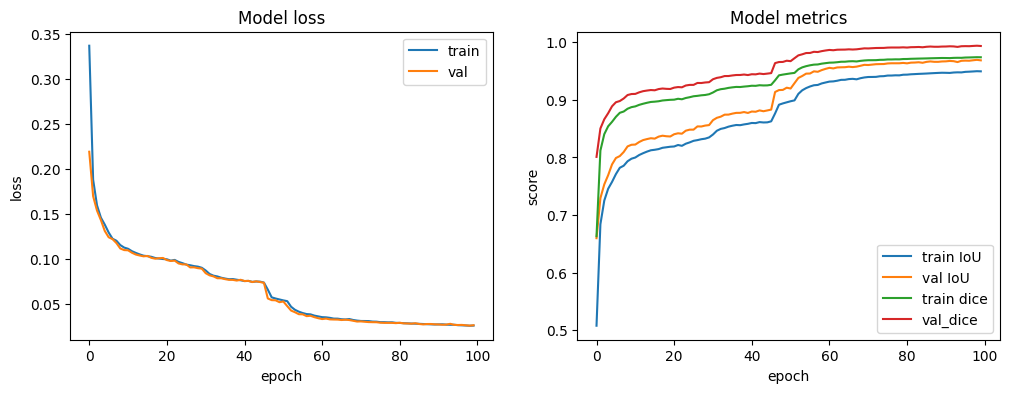

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'])
plt.plot(H['train_DC'])
plt.plot(H['test_DC'])
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [15]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [16]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 120:-120,:]
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 120:-120,:]
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

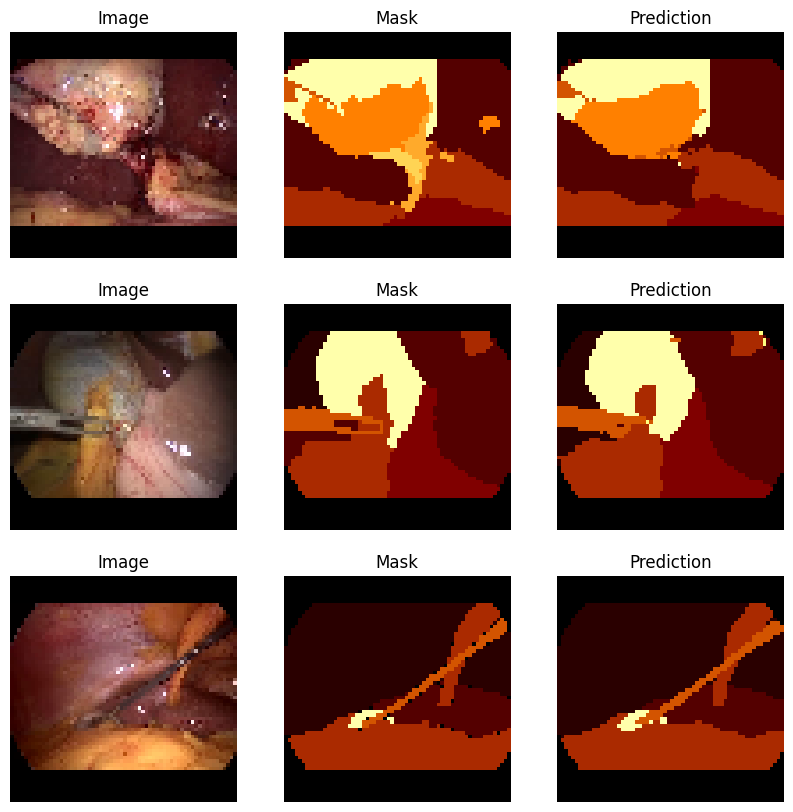

In [17]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='afmhot', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='afmhot', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

--
**TFG - Adrián Contreras Castillo**
--